In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install relevant packages
# !pip install openpyxl==3.0.0    # upgrade from version 2

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import random
import multiprocessing as mp
import dill
import progressbar
import datetime

%load_ext autoreload
%autoreload 2

In [ ]:
# Install more packages
# !pip uninstall geopandas
!pip install pandas fiona shapely pyproj rtree
!pip install geopandas
import pandas as pd
import geopandas as gpd
import rtree
from shapely.geometry import Point, Polygon
root_path = '/content/drive/'
shapedata_path = root_path + 'MyDrive/Distributionpaper/ShapefileData/'
welldata_path = root_path + 'MyDrive/Distributionpaper/WellData/'
result_path = root_path + 'MyDrive/Distributionpaper/results/'
emission_source_path = root_path + 'MyDrive/Distributionpaper/Emission sources/'

# Load state boundary shapefiles
# States shapefiles are from the US Census
# https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html
states = gpd.GeoDataFrame.from_file(shapedata_path + 'cb_2018_us_state_500k.shp')
usa_shape = gpd.GeoDataFrame.from_file(shapedata_path + 'cb_2018_us_nation_20m.shp')
# Rivers and lakes shapefiles from USGS
# https://www.sciencebase.gov/catalog/item/4fb55df0e4b04cb937751e02
rivers = gpd.GeoDataFrame.from_file(shapedata_path + '/basemaps/rivers/hydrography_l_rivers_v2.shp').to_crs("EPSG:4326")
lakes = gpd.GeoDataFrame.from_file(shapedata_path + '/basemaps/lakes/hydrography_p_lakes_v2.shp').to_crs("EPSG:4326")
# Flanders Marine Institute (2021). Global Oceans and Seas, version 1.
# Available online at https://www.marineregions.org/. https://doi.org/10.14284/542
oceans = gpd.GeoDataFrame.from_file(shapedata_path + '/basemaps/GOaS_v1_20211214/goas_v01.shp')
# Countries and lakes, 110m
# http://www.naturalearthdata.com/downloads/
countries = gpd.GeoDataFrame.from_file(shapedata_path + '/basemaps/Natural Earth cultural/10m_cultural/ne_10m_admin_0_countries_tlc.shp')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.7 MB 6.7 MB/s 
     |████████████████████████████████| 6.3 MB 40.1 MB/s 
     |████████████████████████████████| 1.0 MB 56.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 7.6 MB/s 


In [ ]:
# Set color palette
# colors = np.array(['black', '#007C92', '#C74632', '#D1660F', '#7F7776', 'midnightblue', '#734675', 'peru'])
colors = np.array(['black', '#007C92', '#C74632', '#D1660F', '#7F7776', 'dodgerblue', '#734675', 'peru', 'midnightblue'])

In [ ]:
# Import all AAPG basins
# Source: https://ngmdb.usgs.gov/Geolex/stratres/provinces
basin = gpd.GeoDataFrame.from_file(shapedata_path + 'AAPGGeologicProvinces.shp')

# Campaign shapefiles
all_shapefiles_names =  ['Permian_2019', 'Permian_2020', 'Permian_fall2021', 'Permian_summer2021', 'Cal_2016', 'Cal_2017', 'Cal_fall2020', 'Cal_summer2020', 'Cal_fall2021', 'Denver_summer2021', 'Denver_fall2021', 'Northeast_2021', 'Utah_2020', 'Permian_2019', 'Permian_2019', 'Permian_2019'],
all_flightlines = gpd.GeoDataFrame.from_file(shapedata_path + all_shapefiles_names[0][0] + '.shp')
all_flightlines['geometry'] = all_flightlines.buffer(0.01) # Add buffer to prevent null values
full_campaign_all = all_flightlines.dissolve(by='campaign', aggfunc='first')

# Add shapefiles of all campaigns into a single geodataframe
for jj in np.arange(1, len(all_shapefiles_names[0])):
  all_flightlines = gpd.GeoDataFrame.from_file(shapedata_path + all_shapefiles_names[0][jj] + '.shp')
  all_flightlines['geometry'] = all_flightlines.buffer(0.01) # Add buffer to prevent null values
  full_campaign = all_flightlines.dissolve(by='campaign', aggfunc='first')
  full_campaign_all = full_campaign_all.append(full_campaign, ignore_index=True)
full_campaign_all


,geometry,OBJECTID,flightline,date,datetime,platform,Shape_Leng,Shape_Area,year
0,"MULTIPOLYGON (((-104.45466 31.81234, -104.4556...",1.0,ang20190922t165753,2019-09-22,2019-09-22T16:57:53Z,ang,1.043559,0.013855,NaN
1,"MULTIPOLYGON (((-104.13367 31.68824, -104.1338...",1.0,GAO20200713t153738p0000,2020-07-13,2020-07-13T15:37:38Z,gao,0.818307,0.011734,NaN
2,"MULTIPOLYGON (((-104.03545 31.66445, -104.0344...",1.0,GAO20211003t155009p0000,2021-10-03,2021-10-03T15:50:09Z,gao,1.453565,0.017819,NaN
3,"MULTIPOLYGON (((-103.39563 32.11359, -103.3953...",1.0,GAO20210726t172258p0000,2021-07-26,2021-07-26T17:22:58Z,gao,1.751722,0.027683,NaN
4,"MULTIPOLYGON (((-120.82792 35.89997, -120.8288...",1.0,ang20160910t181320,2016-09-10,2016-09-10T18:13:20Z,NaN,0.354608,0.002793,2016.0
5,"MULTIPOLYGON (((-122.28067 37.22922, -122.2815...",523.0,ang20170309t191207,2017-03-09,2017-03-09T19:12:07Z,NaN,0.409453,0.005102,2017.0
6,"MULTIPOLYGON (((-120.11795 36.71773, -120.1171...",1.0,GAO20201109t180309p0000,2020-11-09,2020-11-09T18:03:09Z,gao,0.677441,0.005179,NaN
7,"MULTIPOLYGON (((-119.82407 34.33364, -119.8245...",1.0,ang20200720t193827,2020-07-20,2020-07-20T19:38:27Z,ang,0.186070,0.001418,NaN
8,"MULTIPOLYGON (((-119.70128 35.49364, -119.7008...",1.0,GAO20211105t172926p0000,2021-11-05,2021-11-05T17:29:26Z,gao,0.322895,0.002498,NaN
9,"MULTIPOLYGON (((-104.75154 39.91860, -104.7520...",1.0,GAO20210712t153850p0000,2021-07-12,2021-07-12T15:38:50Z,gao,2.115293,0.016221,NaN


In [ ]:
# Merge all campaign shapefiles for each survyed basin
Permian_campaign_all = full_campaign_all.iloc[0:3, :].dissolve(aggfunc='first')
CA_campaign_all = full_campaign_all.iloc[4:8, :].dissolve(aggfunc='first')
DJ_campaign_all = full_campaign_all.iloc[9:10, :].dissolve(aggfunc='first')
PA_campaign_all = full_campaign_all.iloc[11, :]
Uinta_campaign_all = full_campaign_all.iloc[12, :]

In [ ]:
# Load well data

# Converts data frame to geodf (to convert CSV files to geodataframes)
# df: Input data frame
# latname: Latitude coordinate name
# lonname: Longitude coordinate name
def cvt_point_to_geodf(df,latname='lat',lonname='lon'):
    df['coords'] = list(zip(df[lonname],df[latname]))
    df['coords'] = df['coords'].apply(Point)
    gdf = gpd.GeoDataFrame(df, geometry='coords')
    return gdf

# Load wells in the Permian in 2021 (Texas and New Mexico)
permian_wells = pd.read_csv(welldata_path + 'Permian_2021_welldata.csv')
permian_wells = cvt_point_to_geodf(permian_wells, lonname='Surface Hole Longitude (WGS84)', latname='Surface Hole Latitude (WGS84)')

# Load wells in California in 2021
CA_wells = pd.read_csv(welldata_path + 'CA_2021_welldata.csv')
CA_wells = cvt_point_to_geodf(CA_wells, lonname='Surface Hole Longitude (WGS84)', latname='Surface Hole Latitude (WGS84)')

# Load wells in the Denver-Julesburg in 2021
DJ_wells = pd.read_csv(welldata_path + 'DJ_2021_welldata.csv')
DJ_wells = cvt_point_to_geodf(DJ_wells, lonname='Surface Hole Longitude (WGS84)', latname='Surface Hole Latitude (WGS84)')

# Load wells in Pennsylvania in 2021
PA_wells = pd.read_csv(welldata_path + 'APP_2021_welldata.csv')
PA_wells = cvt_point_to_geodf(PA_wells, lonname='Surface Hole Longitude (WGS84)', latname='Surface Hole Latitude (WGS84)')

# Load wells in Utah in 2021
UT_wells = pd.read_csv(welldata_path + 'UT_2020_welldata.csv')
UT_wells = cvt_point_to_geodf(UT_wells, lonname='Surface Hole Longitude (WGS84)', latname='Surface Hole Latitude (WGS84)')

# Load wells in the Fort Worth in 2021
FW_wells = pd.read_csv(welldata_path + 'TX_2021_FW_welldata.csv')
FW_wells = cvt_point_to_geodf(FW_wells, lonname='Surface Hole Longitude (WGS84)', latname='Surface Hole Latitude (WGS84)')

# Load wells in the rest of the US except the central South
rest_of_US_no_South_Central_wells = pd.read_csv(welldata_path + 'Active_headers_no_South_Central_Well_Headers.csv')
rest_of_US_no_South_Central_wells = cvt_point_to_geodf(rest_of_US_no_South_Central_wells, lonname='Surface Hole Longitude (WGS84)', latname='Surface Hole Latitude (WGS84)')

# Load wells in the rest of the US in the central South
rest_of_South_Central_wells = pd.read_csv(welldata_path + 'Active_headers_remaining_South_Central_Well_Headers.csv')
rest_of_South_Central_wells = cvt_point_to_geodf(rest_of_South_Central_wells, lonname='Surface Hole Longitude (WGS84)', latname='Surface Hole Latitude (WGS84)')

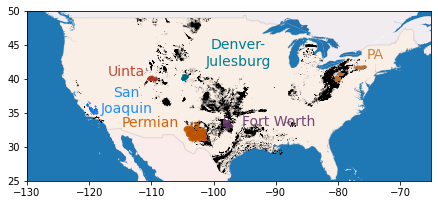

In [ ]:
# Make the national plot
national_plot, ax = plt.subplots()
selected_basins = ['Permian basin', 'San Joaquin basin', 'Denver basin', 'Uinta basin', 'Fort Worth syncline']
selected_basin_shapefile = basin.loc[(basin['Name']==selected_basins[0]) |
                                     (basin['Name']==selected_basins[1]) |
                                     (basin['Name']==selected_basins[2]) |
                                     (basin['Name']==selected_basins[3]) |
                                     (basin['Name']==selected_basins[4]), :]

# Create Appalachian PA shapefile
Appalachian_shape = basin.loc[(basin['Name']=='Appalachian basin (eastern overthrust area)')]
Pennsylvania_shape = states.loc[(states['NAME']=='Pennsylvania')]
Appalachian_PA_shape = Appalachian_shape.intersection(Pennsylvania_shape, align=False)

# Map out USA boundaries, including oceans and lakes
# usa_shape.plot(edgecolor='black', color='white', ax=ax)
usa_shape.plot(edgecolor='black', color=colors[3], alpha=0.1, ax=ax)
oceans[oceans['name']=='North Atlantic Ocean'].plot(ax=ax)
oceans[oceans['name']=='North Pacific Ocean'].plot(ax=ax)
lakes[lakes['NAMEEN']=='Lake Erie'].plot(ax=ax)
lakes[lakes['NAMEEN']=='Lake Huron'].plot(ax=ax)
lakes[lakes['NAMEEN']=='Lake Michigan'].plot(ax=ax)
lakes[lakes['NAMEEN']=='Lake Ontario'].plot(ax=ax)
lakes[lakes['NAMEEN']=='Lake Superior'].plot(ax=ax)
countries[countries['NAME']=='Canada'].plot(color=colors[6], alpha=0.1, ax=ax)
countries[countries['NAME']=='Mexico'].plot(color=colors[2], alpha=0.1, ax=ax)

# Plot all wells in the US as background
background_marker_size = 0.0005 # 0.0001
background_alpha = 0.2 # 0.3
plt.scatter(x=rest_of_US_no_South_Central_wells['Surface Hole Longitude (WGS84)'], y=rest_of_US_no_South_Central_wells['Surface Hole Latitude (WGS84)'], s=background_marker_size, marker='.', alpha=background_alpha, color=colors[0])
plt.scatter(x=rest_of_South_Central_wells['Surface Hole Longitude (WGS84)'], y=rest_of_South_Central_wells['Surface Hole Latitude (WGS84)'], s=background_marker_size, marker='.', alpha=background_alpha, color=colors[0])
plt.scatter(x=permian_wells['Surface Hole Longitude (WGS84)'], y=permian_wells['Surface Hole Latitude (WGS84)'], s=background_marker_size, marker='.', alpha=background_alpha, color=colors[0])
plt.scatter(x=CA_wells['Surface Hole Longitude (WGS84)'], y=CA_wells['Surface Hole Latitude (WGS84)'], s=background_marker_size, marker='.', alpha=background_alpha, color=colors[0])
plt.scatter(x=DJ_wells['Surface Hole Longitude (WGS84)'], y=DJ_wells['Surface Hole Latitude (WGS84)'], s=background_marker_size, marker='.', alpha=background_alpha, color=colors[0])
plt.scatter(x=UT_wells['Surface Hole Longitude (WGS84)'], y=UT_wells['Surface Hole Latitude (WGS84)'], s=background_marker_size, marker='.', alpha=background_alpha, color=colors[0])
plt.scatter(x=PA_wells['Surface Hole Longitude (WGS84)'], y=PA_wells['Surface Hole Latitude (WGS84)'], s=background_marker_size, marker='.', alpha=background_alpha, color=colors[0])

foreground_marker_size = 0.001

# Create combined plot of wells intersected with aerial flightlines
Permian_campaign_all = full_campaign_all.iloc[0:3, :].dissolve(aggfunc='first')
CA_campaign_all = full_campaign_all.iloc[4:8, :].dissolve(aggfunc='first')
DJ_campaign_all = full_campaign_all.iloc[9:10, :].dissolve(aggfunc='first')
PA_campaign_all = full_campaign_all.iloc[11, :]
Uinta_campaign_all = full_campaign_all.iloc[12, :]

# Create San Joaquin-only shapefile for California (excluding coverage in other basins)
San_Joaquin_shape = basin[basin['Name'] == 'San Joaquin basin']
San_Joaquin_campaigns_only = gpd.GeoDataFrame({'geometry':San_Joaquin_shape.intersection(CA_campaign_all, align=False)})

# Pick out covered wells only in each of the selected regions
# Add each of these to the plot in the selected color
denver_wells_only = gpd.tools.sjoin(DJ_wells,DJ_campaign_all,op='within',how='inner')
plt.scatter(x=denver_wells_only['Surface Hole Longitude (WGS84)'], y=denver_wells_only['Surface Hole Latitude (WGS84)'], s=foreground_marker_size, marker='.', color=colors[1])

uinta_wells_only = gpd.tools.sjoin(UT_wells,gpd.GeoDataFrame(Uinta_campaign_all).transpose(),op='within',how='inner')
plt.scatter(x=uinta_wells_only['Surface Hole Longitude (WGS84)'], y=uinta_wells_only['Surface Hole Latitude (WGS84)'], s=foreground_marker_size, marker='.', color=colors[2])

SJ_wells_only = gpd.tools.sjoin(CA_wells,San_Joaquin_campaigns_only,op='within',how='inner')
plt.scatter(x=SJ_wells_only['Surface Hole Longitude (WGS84)'], y=SJ_wells_only['Surface Hole Latitude (WGS84)'], s=foreground_marker_size, marker='.', color=colors[5])

# Fort Worth includes all wells, as spatially resolved coverage information was not provided by Kairos to protect customer data.
# The Kairos survey covered 52% of wells and 82% of production
FW_wells_only = gpd.tools.sjoin(FW_wells,selected_basin_shapefile.iloc[[3]],op='within',how='inner')
plt.scatter(x=FW_wells_only['Surface Hole Longitude (WGS84)'], y=FW_wells_only['Surface Hole Latitude (WGS84)'], s=foreground_marker_size, marker='.', color=colors[6])

permian_wells_only = gpd.tools.sjoin(permian_wells,Permian_campaign_all,op='within',how='inner')
permian_wells_only = permian_wells_only.loc[permian_wells_only['Surface Hole Longitude (WGS84)'] < -100, :] # Remove the straggling points east of the Permian
plt.scatter(x=permian_wells_only['Surface Hole Longitude (WGS84)'], y=permian_wells_only['Surface Hole Latitude (WGS84)'], s=foreground_marker_size, marker='.', color=colors[3])

PA_wells_only = gpd.tools.sjoin(PA_wells,gpd.GeoDataFrame(PA_campaign_all).transpose(),op='within',how='inner')
plt.scatter(x=PA_wells_only['Surface Hole Longitude (WGS84)'], y=PA_wells_only['Surface Hole Latitude (WGS84)'], s=foreground_marker_size, marker='.', color=colors[7])


# Add text for the name of each basin/region
plt.text(-110.2, 33, 'Permian', size=14, color=colors[3], rotation=0, ha='center')
plt.text(-114, 35, 'San\nJoaquin', size=14, color=colors[5], rotation=0, ha='center')
plt.text(-96, 42, 'Denver-\nJulesburg', size=14, color=colors[1], rotation=0, ha='center')
plt.text(-74, 43, 'PA', size=14, color=colors[7], rotation=0, ha='center')
plt.text(-114, 40.5, 'Uinta', size=14, color=colors[2], rotation=0, ha='center')
plt.text(-89.6, 33.1, 'Fort Worth', size=14, color=colors[6], rotation=0, ha='center')
ax.set_xlim(-130, -65)
ax.set_ylim(25, 50)

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.rcParams["figure.figsize"] = (6,3)
# Save the figure, if uncommented
# plt.savefig(result_path + 'All survey map 20221111f.png', format='png', bbox_inches='tight', dpi=300)

# Show the figure, if the plan is not to save it
plt.show()

Campaign-specific emission figures

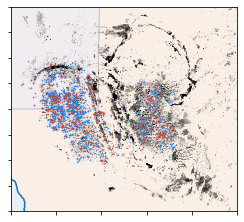

In [ ]:
# CM Permian 2019 plot
Sources_prod = pd.read_csv(emission_source_path + 'Production_sources_P - Permian_2019Permian basin_20221110.csv')
Sources_prod = cvt_point_to_geodf(Sources_prod, lonname='Longitude', latname='Latitude')
Sources_mid = pd.read_csv(emission_source_path + 'Midstream_sources_P - Permian_2019Permian basin_20221110.csv')
Sources_mid = cvt_point_to_geodf(Sources_mid, lonname='Longitude', latname='Latitude')

national_plot, ax = plt.subplots()
# Add state and water boundaries
states.loc[(states['NAME']=='Texas')].plot(edgecolor='black', color=colors[3], alpha=0.1, ax=ax)
states.loc[(states['NAME']=='New Mexico')].plot(edgecolor='black', color=colors[6], alpha=0.1, ax=ax)
countries[countries['NAME']=='Mexico'].plot(color=colors[1], alpha=0.1, ax=ax)
rivers[rivers['NAMEEN'] == 'Rio Grande'].plot(ax=ax) # The Rio Grande

# Plot all wells
plt.scatter(x=permian_wells['Surface Hole Longitude (WGS84)'], y=permian_wells['Surface Hole Latitude (WGS84)'], s=background_marker_size, marker='.', color=colors[0])

# Plot all emissions
plt.scatter(x=Sources_prod['Longitude'], y=Sources_prod['Latitude'], s=1, marker='.', color=colors[5])
plt.scatter(x=Sources_mid['Longitude'], y=Sources_mid['Latitude'], s=1, marker='.', color=colors[2])
# plt.text(-102.8, 33.62, 'Permian', fontsize=18)
# plt.text(-102.5, 33.61, 'Texas', fontsize=18)
# plt.text(-104.2, 33.61, 'NM', fontsize=18)
ax.set_yticklabels([])
ax.set_xticklabels([])
# plt.text(-104.7, 33.2, 'New\nMexico', fontsize=18)

# plt.xlabel('Longitude', size=16)
# plt.ylabel('Latitude', size=16)
ax.set_xlim(-105, -100)
ax.set_ylim(30, 34)
# ax.set_xlim(-105, -101)
# ax.set_ylim(30.5, 34)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
# plt.rcParams["figure.figsize"] = (6,3)

# Save figure
plt.savefig(result_path + 'CM Permian 2019 survey map 20221112.png', format='png', bbox_inches='tight', dpi=300)

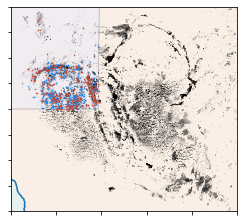

In [ ]:
# Kairos NM Permian plot
Sources_prod = pd.read_csv(emission_source_path + 'Production_sources_Kairos PermianPermian basin_20221110.csv')
Sources_prod = cvt_point_to_geodf(Sources_prod, lonname='Longitude', latname='Latitude')
Sources_mid = pd.read_csv(emission_source_path + 'Midstream_sources_Kairos PermianPermian basin_20221110.csv')
Sources_mid = cvt_point_to_geodf(Sources_mid, lonname='Longitude', latname='Latitude')

national_plot, ax = plt.subplots()
# states.plot(edgecolor='black', color=colors[3], alpha=0.1, ax=ax)
# Add state and water boundaries
states.loc[(states['NAME']=='Texas')].plot(edgecolor='black', color=colors[3], alpha=0.1, ax=ax)
states.loc[(states['NAME']=='New Mexico')].plot(edgecolor='black', color=colors[6], alpha=0.1, ax=ax)
countries[countries['NAME']=='Mexico'].plot(color=colors[1], alpha=0.1, ax=ax)
rivers[rivers['NAMEEN'] == 'Rio Grande'].plot(ax=ax) # The Rio Grande

# Plot all wells
plt.scatter(x=permian_wells['Surface Hole Longitude (WGS84)'], y=permian_wells['Surface Hole Latitude (WGS84)'], s=background_marker_size, marker='.', color=colors[0])

# Plot all emissions
plt.scatter(x=Sources_prod['Longitude'], y=Sources_prod['Latitude'], s=1, marker='.', color=colors[5])
plt.scatter(x=Sources_mid['Longitude'], y=Sources_mid['Latitude'], s=1, marker='.', color=colors[2])
# plt.text(-102.8, 33.62, 'Permian', fontsize=18)
# plt.text(-102.5, 33.61, 'Texas', fontsize=18)
# plt.text(-104.2, 33.61, 'NM', fontsize=18)

ax.set_yticklabels([])
ax.set_xticklabels([])
# plt.xlabel('Longitude', size=16)
# plt.ylabel('Latitude', size=16)
ax.set_xlim(-105, -100)
ax.set_ylim(30, 34)
# ax.set_xlim(-105, -101)
# ax.set_ylim(30.5, 34)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
# plt.rcParams["figure.figsize"] = (6,3)
plt.savefig(result_path + 'Kairos Permian 2018-2020 survey map 20221112.png', format='png', bbox_inches='tight', dpi=300)

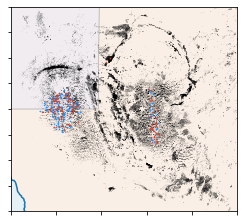

In [ ]:
# CM 2020 Permian
Sources_prod = pd.read_csv(emission_source_path + 'Production_sources_F - GAO_2020Permian basin_20221110.csv')
Sources_prod = cvt_point_to_geodf(Sources_prod, lonname='Longitude', latname='Latitude')
Sources_mid = pd.read_csv(emission_source_path + 'Midstream_sources_F - GAO_2020Permian basin_20221110.csv')
Sources_mid = cvt_point_to_geodf(Sources_mid, lonname='Longitude', latname='Latitude')

national_plot, ax = plt.subplots()
# states.plot(edgecolor='black', color=colors[3], alpha=0.1, ax=ax)

# Add state and water boundaries
states.loc[(states['NAME']=='Texas')].plot(edgecolor='black', color=colors[3], alpha=0.1, ax=ax)
states.loc[(states['NAME']=='New Mexico')].plot(edgecolor='black', color=colors[6], alpha=0.1, ax=ax)
countries[countries['NAME']=='Mexico'].plot(color=colors[1], alpha=0.1, ax=ax)
rivers[rivers['NAMEEN'] == 'Rio Grande'].plot(ax=ax) # The Rio Grande

# Plot all wells
plt.scatter(x=permian_wells['Surface Hole Longitude (WGS84)'], y=permian_wells['Surface Hole Latitude (WGS84)'], s=background_marker_size, marker='.', color=colors[0])

# Plot all emissions
plt.scatter(x=Sources_prod['Longitude'], y=Sources_prod['Latitude'], s=1, marker='.', color=colors[5])
plt.scatter(x=Sources_mid['Longitude'], y=Sources_mid['Latitude'], s=1, marker='.', color=colors[2])
# plt.text(-102.8, 33.62, 'Permian', fontsize=18)
# plt.text(-102.5, 33.61, 'Texas', fontsize=18)
# plt.text(-104.2, 33.61, 'NM', fontsize=18)

ax.set_yticklabels([])
ax.set_xticklabels([])
# plt.xlabel('Longitude', size=16)
# plt.ylabel('Latitude', size=16)
ax.set_xlim(-105, -100)
ax.set_ylim(30, 34)
# ax.set_xlim(-105, -101)
# ax.set_ylim(30.5, 34)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
# plt.rcParams["figure.figsize"] = (6,3)
plt.savefig(result_path + 'CM Permian 2020 survey map 20221112.png', format='png', bbox_inches='tight', dpi=300)

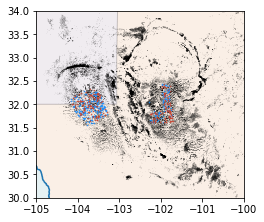

In [ ]:
# CM Summer 2021 Permian
Sources_prod = pd.read_csv(emission_source_path + 'Production_sources_E - Permian_2021Permian basin_20221110.csv')
Sources_prod = cvt_point_to_geodf(Sources_prod, lonname='Longitude', latname='Latitude')
Sources_mid = pd.read_csv(emission_source_path + 'Midstream_sources_E - Permian_2021Permian basin_20221110.csv')
Sources_mid = cvt_point_to_geodf(Sources_mid, lonname='Longitude', latname='Latitude')

national_plot, ax = plt.subplots()
# states.plot(edgecolor='black', color=colors[3], alpha=0.1, ax=ax)

# Add state and water boundaries
states.loc[(states['NAME']=='Texas')].plot(edgecolor='black', color=colors[3], alpha=0.1, ax=ax)
states.loc[(states['NAME']=='New Mexico')].plot(edgecolor='black', color=colors[6], alpha=0.1, ax=ax)
countries[countries['NAME']=='Mexico'].plot(color=colors[1], alpha=0.1, ax=ax)
rivers[rivers['NAMEEN'] == 'Rio Grande'].plot(ax=ax) # The Rio Grande

# Plot all wells
plt.scatter(x=permian_wells['Surface Hole Longitude (WGS84)'], y=permian_wells['Surface Hole Latitude (WGS84)'], s=background_marker_size, marker='.', color=colors[0])

# Plot all emissions
plt.scatter(x=Sources_prod['Longitude'], y=Sources_prod['Latitude'], s=1, marker='.', color=colors[5])
plt.scatter(x=Sources_mid['Longitude'], y=Sources_mid['Latitude'], s=1, marker='.', color=colors[2])
# plt.text(-102.8, 33.62, 'Permian', fontsize=18)
# plt.text(-102.5, 33.61, 'Texas', fontsize=18)
# plt.text(-104.2, 33.61, 'NM', fontsize=18)

# plt.xlabel('Longitude', size=16)
# plt.ylabel('Latitude', size=16)
ax.set_xlim(-105, -100)
ax.set_ylim(30, 34)
# ax.set_xlim(-105, -101)
# ax.set_ylim(30.5, 34)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
# plt.rcParams["figure.figsize"] = (6,3)
plt.savefig(result_path + 'CM Permian summer 2021 survey map 20221112.png', format='png', bbox_inches='tight', dpi=300)

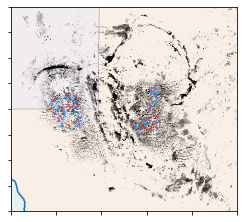

In [ ]:
# CM Fall 2021 Permian
Sources_prod = pd.read_csv(emission_source_path + 'Production_sources_J - Permian Fall 2021Permian basin_20221110.csv')
Sources_prod = cvt_point_to_geodf(Sources_prod, lonname='Longitude', latname='Latitude')
Sources_mid = pd.read_csv(emission_source_path + 'Midstream_sources_J - Permian Fall 2021Permian basin_20221110.csv')
Sources_mid = cvt_point_to_geodf(Sources_mid, lonname='Longitude', latname='Latitude')

national_plot, ax = plt.subplots()
# states.plot(edgecolor='black', color=colors[3], alpha=0.1, ax=ax)

# Add state and water boundaries
states.loc[(states['NAME']=='Texas')].plot(edgecolor='black', color=colors[3], alpha=0.1, ax=ax)
states.loc[(states['NAME']=='New Mexico')].plot(edgecolor='black', color=colors[6], alpha=0.1, ax=ax)
countries[countries['NAME']=='Mexico'].plot(color=colors[1], alpha=0.1, ax=ax)
rivers[rivers['NAMEEN'] == 'Rio Grande'].plot(ax=ax) # The Rio Grande

# Plot all wells
plt.scatter(x=permian_wells['Surface Hole Longitude (WGS84)'], y=permian_wells['Surface Hole Latitude (WGS84)'], s=background_marker_size, marker='.', color=colors[0])

# Plot all emissions
plt.scatter(x=Sources_prod['Longitude'], y=Sources_prod['Latitude'], s=1, marker='.', color=colors[5])
plt.scatter(x=Sources_mid['Longitude'], y=Sources_mid['Latitude'], s=1, marker='.', color=colors[2])
# plt.text(-102.8, 33.62, 'Permian', fontsize=18)
# plt.text(-102.5, 33.61, 'Texas', fontsize=18)
# plt.text(-104.2, 33.61, 'NM', fontsize=18)

ax.set_yticklabels([])
ax.set_xticklabels([])
# plt.xlabel('Longitude', size=16)
# plt.ylabel('Latitude', size=16)
ax.set_xlim(-105, -100)
ax.set_ylim(30, 34)
# ax.set_xlim(-105, -101)
# ax.set_ylim(30.5, 34)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
# plt.rcParams["figure.figsize"] = (6,3)
plt.savefig(result_path + 'CM Permian fall 2021 survey map 20221112.png', format='png', bbox_inches='tight', dpi=300)

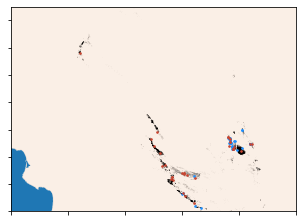

In [ ]:
# CM 2016 San Joaquin
Sources_prod = pd.read_csv(emission_source_path + 'Production_sources_CA 2016San Joaquin basin_20221110.csv')
Sources_prod = cvt_point_to_geodf(Sources_prod, lonname='Longitude', latname='Latitude')
Sources_mid = pd.read_csv(emission_source_path + 'Midstream_sources_CA 2016San Joaquin basin_20221110.csv')
Sources_mid = cvt_point_to_geodf(Sources_mid, lonname='Longitude', latname='Latitude')

national_plot, ax = plt.subplots()
# states.plot(edgecolor='black', color=colors[3], alpha=0.1, ax=ax)

# Add state and water boundaries
states.loc[(states['NAME']=='California')].plot(edgecolor='black', color=colors[3], alpha=0.1, ax=ax)
states.loc[(states['NAME']=='Nevada')].plot(edgecolor='black', color=colors[6], alpha=0.1, ax=ax)
oceans[oceans['name']=='North Pacific Ocean'].plot(ax=ax)

# Plot all wells
plt.scatter(x=SJ_wells_only['Surface Hole Longitude (WGS84)'], y=SJ_wells_only['Surface Hole Latitude (WGS84)'], s=background_marker_size, alpha=0.4, marker='.', color=colors[0])

# Plot all emissions
plt.scatter(x=Sources_prod['Longitude'], y=Sources_prod['Latitude'], s=10, marker='.', color=colors[5])
plt.scatter(x=Sources_mid['Longitude'], y=Sources_mid['Latitude'], s=10, marker='.', color=colors[2])
# plt.text(-120.2, 36.2, 'California', fontsize=18)
# plt.text(-120.1, 36, 'San Joaquin\n(California)', fontsize=18)

ax.set_yticklabels([])
ax.set_xticklabels([])
# plt.xlabel('Longitude', size=14)
# plt.ylabel('Latitude', size=14)
ax.set_xlim(-121, -118.5)
ax.set_ylim(35, 36.5)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
# plt.rcParams["figure.figsize"] = (6,3)
plt.savefig(result_path + 'CM San Joaquin 2016 survey map 20221112.png', format='png', bbox_inches='tight', dpi=300)

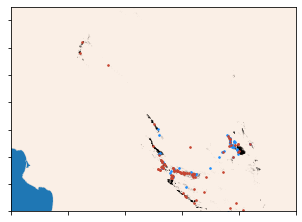

In [ ]:
# CM 2017 San Joaquin
Sources_prod = pd.read_csv(emission_source_path + 'Production_sources_CA 2017San Joaquin basin_20221110.csv')
Sources_prod = cvt_point_to_geodf(Sources_prod, lonname='Longitude', latname='Latitude')
Sources_mid = pd.read_csv(emission_source_path + 'Midstream_sources_CA 2017San Joaquin basin_20221110.csv')
Sources_mid = cvt_point_to_geodf(Sources_mid, lonname='Longitude', latname='Latitude')

national_plot, ax = plt.subplots()
# states.plot(edgecolor='black', color=colors[3], alpha=0.1, ax=ax)

# Add state and water boundaries
states.loc[(states['NAME']=='California')].plot(edgecolor='black', color=colors[3], alpha=0.1, ax=ax)
oceans[oceans['name']=='North Pacific Ocean'].plot(ax=ax)

# Plot all wells
plt.scatter(x=SJ_wells_only['Surface Hole Longitude (WGS84)'], y=SJ_wells_only['Surface Hole Latitude (WGS84)'], s=background_marker_size, alpha=0.4, marker='.', color=colors[0])

# Plot all emissions
plt.scatter(x=Sources_prod['Longitude'], y=Sources_prod['Latitude'], s=10, marker='.', color=colors[5])
plt.scatter(x=Sources_mid['Longitude'], y=Sources_mid['Latitude'], s=10, marker='.', color=colors[2])
# plt.text(-120.2, 36.2, 'California', fontsize=18)
# plt.text(-120.1, 36, 'San Joaquin\n(California)', fontsize=18)

ax.set_yticklabels([])
ax.set_xticklabels([])
# plt.xlabel('Longitude', size=14)
# plt.ylabel('Latitude', size=14)
ax.set_xlim(-121, -118.5)
ax.set_ylim(35, 36.5)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
# plt.rcParams["figure.figsize"] = (6,3)
plt.savefig(result_path + 'CM San Joaquin 2017 survey map 20221112.png', format='png', bbox_inches='tight', dpi=300)

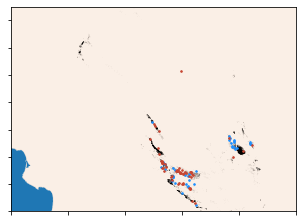

In [ ]:
# CM summer 2020 San Joaquin
Sources_prod = pd.read_csv(emission_source_path + 'Production_sources_H - COVID_CA_2020San Joaquin basin_20221110.csv')
Sources_prod = cvt_point_to_geodf(Sources_prod, lonname='Longitude', latname='Latitude')
Sources_mid = pd.read_csv(emission_source_path + 'Midstream_sources_H - COVID_CA_2020San Joaquin basin_20221110.csv')
Sources_mid = cvt_point_to_geodf(Sources_mid, lonname='Longitude', latname='Latitude')

national_plot, ax = plt.subplots()
# states.plot(edgecolor='black', color=colors[3], alpha=0.1, ax=ax)

# Add state and water boundaries
states.loc[(states['NAME']=='California')].plot(edgecolor='black', color=colors[3], alpha=0.1, ax=ax)
oceans[oceans['name']=='North Pacific Ocean'].plot(ax=ax)

# Plot all wells
plt.scatter(x=SJ_wells_only['Surface Hole Longitude (WGS84)'], y=SJ_wells_only['Surface Hole Latitude (WGS84)'], s=background_marker_size, alpha=0.4, marker='.', color=colors[0])

# Plot all emissions
plt.scatter(x=Sources_prod['Longitude'], y=Sources_prod['Latitude'], s=10, marker='.', color=colors[5])
plt.scatter(x=Sources_mid['Longitude'], y=Sources_mid['Latitude'], s=10, marker='.', color=colors[2])
# plt.text(-120.1, 36, 'San Joaquin\n(California)', fontsize=18)

ax.set_yticklabels([])
ax.set_xticklabels([])
# plt.xlabel('Longitude', size=14)
# plt.ylabel('Latitude', size=14)
ax.set_xlim(-121, -118.5)
ax.set_ylim(35, 36.5)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
# plt.rcParams["figure.figsize"] = (6,3)
plt.savefig(result_path + 'CM San Joaquin summer 2020 survey map 20221112.png', format='png', bbox_inches='tight', dpi=300)

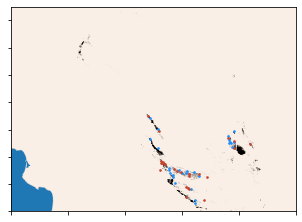

In [ ]:
# CM fall 2020 San Joaquin
Sources_prod = pd.read_csv(emission_source_path + 'Production_sources_G - CA_2020San Joaquin basin_20221110.csv')
Sources_prod = cvt_point_to_geodf(Sources_prod, lonname='Longitude', latname='Latitude')
Sources_mid = pd.read_csv(emission_source_path + 'Midstream_sources_G - CA_2020San Joaquin basin_20221110.csv')
Sources_mid = cvt_point_to_geodf(Sources_mid, lonname='Longitude', latname='Latitude')

national_plot, ax = plt.subplots()
# states.plot(edgecolor='black', color=colors[3], alpha=0.1, ax=ax)

# Add state and water boundaries
states.loc[(states['NAME']=='California')].plot(edgecolor='black', color=colors[3], alpha=0.1, ax=ax)
states.loc[(states['NAME']=='Nevada')].plot(edgecolor='black', color=colors[6], alpha=0.1, ax=ax)
oceans[oceans['name']=='North Pacific Ocean'].plot(ax=ax)

# Plot all wells
plt.scatter(x=SJ_wells_only['Surface Hole Longitude (WGS84)'], y=SJ_wells_only['Surface Hole Latitude (WGS84)'], s=background_marker_size, alpha=0.4, marker='.', color=colors[0])

#Plot all emissions
plt.scatter(x=Sources_prod['Longitude'], y=Sources_prod['Latitude'], s=10, marker='.', color=colors[5])
plt.scatter(x=Sources_mid['Longitude'], y=Sources_mid['Latitude'], s=10, marker='.', color=colors[2])
# plt.text(-120.1, 36, 'San Joaquin\n(California)', fontsize=18)

ax.set_yticklabels([])
ax.set_xticklabels([])
# plt.xlabel('Longitude', size=14)
# plt.ylabel('Latitude', size=14)
ax.set_xlim(-121, -118.5)
ax.set_ylim(35, 36.5)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
# plt.rcParams["figure.figsize"] = (6,3)
plt.savefig(result_path + 'CM San Joaquin fall 2020 survey map 20221112.png', format='png', bbox_inches='tight', dpi=300)

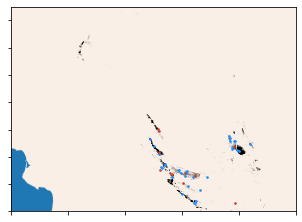

In [ ]:
# CM fall 2021 San Joaquin
Sources_prod = pd.read_csv(emission_source_path + 'Production_sources_K - CA Fall 2021San Joaquin basin_20221110.csv')
Sources_prod = cvt_point_to_geodf(Sources_prod, lonname='Longitude', latname='Latitude')
Sources_mid = pd.read_csv(emission_source_path + 'Midstream_sources_K - CA Fall 2021San Joaquin basin_20221110.csv')
Sources_mid = cvt_point_to_geodf(Sources_mid, lonname='Longitude', latname='Latitude')

national_plot, ax = plt.subplots()
# states.plot(edgecolor='black', color=colors[3], alpha=0.1, ax=ax)

# Add state and water boundaries
states.loc[(states['NAME']=='California')].plot(edgecolor='black', color=colors[3], alpha=0.1, ax=ax)
oceans[oceans['name']=='North Pacific Ocean'].plot(ax=ax)

# Plot all wells
plt.scatter(x=SJ_wells_only['Surface Hole Longitude (WGS84)'], y=SJ_wells_only['Surface Hole Latitude (WGS84)'], s=background_marker_size, alpha=0.4, marker='.', color=colors[0])

# Plot all emissions
plt.scatter(x=Sources_prod['Longitude'], y=Sources_prod['Latitude'], s=10, marker='.', color=colors[5])
plt.scatter(x=Sources_mid['Longitude'], y=Sources_mid['Latitude'], s=10, marker='.', color=colors[2])
# plt.text(-120.1, 36, 'San Joaquin\n(California)', fontsize=18)

ax.set_yticklabels([])
ax.set_xticklabels([])
# plt.xlabel('Longitude', size=14)
# plt.ylabel('Latitude', size=14)
ax.set_xlim(-121, -118.5)
ax.set_ylim(35, 36.5)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
# plt.rcParams["figure.figsize"] = (6,3)
plt.savefig(result_path + 'CM San Joaquin fall 2021 survey map 20221112.png', format='png', bbox_inches='tight', dpi=300)

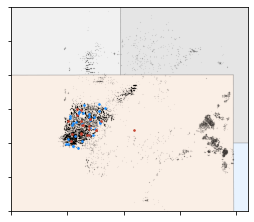

In [ ]:
# CM fall 2021 DJ
Sources_prod = pd.read_csv(emission_source_path + 'Production_sources_I - DJ Fall 2021Denver basin_20221110.csv')
Sources_prod = cvt_point_to_geodf(Sources_prod, lonname='Longitude', latname='Latitude')
Sources_mid = pd.read_csv(emission_source_path + 'Midstream_sources_I - DJ Fall 2021Denver basin_20221110.csv')
Sources_mid = cvt_point_to_geodf(Sources_mid, lonname='Longitude', latname='Latitude')

# Create Denver Julesburg-only shapefile for California (excluding coverage in other basins)
DJ_shape = basin[basin['Name'] == 'Denver basin']
DJ_wells_all = gpd.tools.sjoin(DJ_wells,DJ_shape,op='within',how='inner')


national_plot, ax = plt.subplots()
# states.plot(edgecolor='black', color=colors[3], alpha=0.1, ax=ax)

# Add state and water boundaries
states.loc[(states['NAME']=='Colorado')].plot(edgecolor='black', color=colors[3], alpha=0.1, ax=ax)
states.loc[(states['NAME']=='Utah')].plot(edgecolor='black', color=colors[1], alpha=0.1, ax=ax)
states.loc[(states['NAME']=='Arizona')].plot(edgecolor='black', color=colors[2], alpha=0.1, ax=ax)
states.loc[(states['NAME']=='Wyoming')].plot(edgecolor='black', color=colors[4], alpha=0.1, ax=ax)
states.loc[(states['NAME']=='Kansas')].plot(edgecolor='black', color=colors[5], alpha=0.1, ax=ax)
states.loc[(states['NAME']=='Nebraska')].plot(edgecolor='black', color=colors[0], alpha=0.1, ax=ax)
states.loc[(states['NAME']=='Oklahoma')].plot(edgecolor='black', color=colors[6], alpha=0.1, ax=ax)
states.loc[(states['NAME']=='Nevada')].plot(edgecolor='black', color=colors[7], alpha=0.1, ax=ax)
states.loc[(states['NAME']=='New Mexico')].plot(edgecolor='black', color=colors[8], alpha=0.1, ax=ax)

# Plot all wells
plt.scatter(x=DJ_wells_all['Surface Hole Longitude (WGS84)'], y=DJ_wells_all['Surface Hole Latitude (WGS84)'], s=background_marker_size*3, alpha=1, marker='.', color=colors[0])

# Plot all emissions
plt.scatter(x=Sources_prod['Longitude'], y=Sources_prod['Latitude'], s=10, marker='.', color=colors[5])
plt.scatter(x=Sources_mid['Longitude'], y=Sources_mid['Latitude'], s=10, marker='.', color=colors[2])
# plt.text(-105.9, 39.2, 'Denver-Julesburg', fontsize=20)

ax.set_yticklabels([])
ax.set_xticklabels([])
# plt.xlabel('Longitude', size=16)
# plt.ylabel('Latitude', size=16)
ax.set_xlim(-106, -101.8)
ax.set_ylim(39, 42)
# ax.set_ylim(39, 41.1)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
# plt.rcParams["figure.figsize"] = (6,3)
plt.savefig(result_path + 'CM Denver-Julesburg fall 2021 survey map 20221112.png', format='png', bbox_inches='tight', dpi=300)

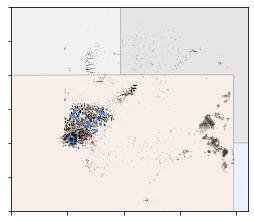

In [ ]:
# CM summer 2021 DJ
Sources_prod = pd.read_csv(emission_source_path + 'Production_sources_A - DJ_Summer_2021Denver basin_20221110.csv')
Sources_prod = cvt_point_to_geodf(Sources_prod, lonname='Longitude', latname='Latitude')
Sources_mid = pd.read_csv(emission_source_path + 'Midstream_sources_A - DJ_Summer_2021Denver basin_20221110.csv')
Sources_mid = cvt_point_to_geodf(Sources_mid, lonname='Longitude', latname='Latitude')

# Create Denver Julesburg-only shapefile for California (excluding coverage in other basins)
DJ_shape = basin[basin['Name'] == 'Denver basin']
DJ_wells_all = gpd.tools.sjoin(DJ_wells,DJ_shape,op='within',how='inner')


national_plot, ax = plt.subplots()
# states.plot(edgecolor='black', color=colors[3], alpha=0.1, ax=ax)

# Add state and water boundaries
states.loc[(states['NAME']=='Colorado')].plot(edgecolor='black', color=colors[3], alpha=0.1, ax=ax)
states.loc[(states['NAME']=='Utah')].plot(edgecolor='black', color=colors[1], alpha=0.1, ax=ax)
states.loc[(states['NAME']=='Arizona')].plot(edgecolor='black', color=colors[2], alpha=0.1, ax=ax)
states.loc[(states['NAME']=='Wyoming')].plot(edgecolor='black', color=colors[4], alpha=0.1, ax=ax)
states.loc[(states['NAME']=='Kansas')].plot(edgecolor='black', color=colors[5], alpha=0.1, ax=ax)
states.loc[(states['NAME']=='Nebraska')].plot(edgecolor='black', color=colors[0], alpha=0.1, ax=ax)
states.loc[(states['NAME']=='Oklahoma')].plot(edgecolor='black', color=colors[6], alpha=0.1, ax=ax)
states.loc[(states['NAME']=='Nevada')].plot(edgecolor='black', color=colors[7], alpha=0.1, ax=ax)
states.loc[(states['NAME']=='New Mexico')].plot(edgecolor='black', color=colors[8], alpha=0.1, ax=ax)

# Plot all wells
plt.scatter(x=DJ_wells_all['Surface Hole Longitude (WGS84)'], y=DJ_wells_all['Surface Hole Latitude (WGS84)'], s=background_marker_size*3, alpha=1, marker='.', color=colors[0])

# Plot all emissions
plt.scatter(x=Sources_prod['Longitude'], y=Sources_prod['Latitude'], s=10, marker='.', color=colors[5])
plt.scatter(x=Sources_mid['Longitude'], y=Sources_mid['Latitude'], s=10, marker='.', color=colors[2])
# plt.text(-105.9, 39.2, 'Denver-Julesburg', fontsize=20)

ax.set_yticklabels([])
ax.set_xticklabels([])
# plt.xlabel('Longitude', size=16)
# plt.ylabel('Latitude', size=16)
ax.set_xlim(-106, -101.8)
ax.set_ylim(39, 42)
# ax.set_ylim(39, 41.1)

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
# plt.rcParams["figure.figsize"] = (6,3)
plt.savefig(result_path + 'CM Denver-Julesburg summer 2021 survey map 20221112.png', format='png', bbox_inches='tight', dpi=300)

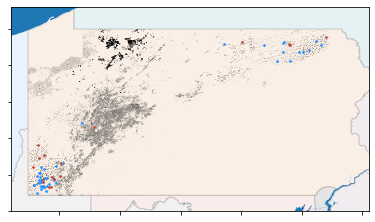

In [ ]:
# CM 2021 Pennsylvania
Sources_prod = pd.read_csv(emission_source_path + 'Production_sources_B - NorthEast_2021Appalachian basin (eastern overthrust area)_20221111b.csv')
Sources_prod = cvt_point_to_geodf(Sources_prod, lonname='Longitude', latname='Latitude')
Sources_mid = pd.read_csv(emission_source_path + 'Midstream_sources_B - NorthEast_2021Appalachian basin (eastern overthrust area)_20221111b.csv')
Sources_mid = cvt_point_to_geodf(Sources_mid, lonname='Longitude', latname='Latitude')

# Create PA-only shapefile (excluding coverage in other basins)
Appalachian_PA_shape_GDF = gpd.GeoDataFrame({'geometry':Appalachian_PA_shape})
PA_wells_all = gpd.tools.sjoin(PA_wells,Appalachian_PA_shape_GDF,op='within',how='inner')


national_plot, ax = plt.subplots()
# states.plot(edgecolor='black', color=colors[3], alpha=0.1, ax=ax)

# Add state and water boundaries
states.loc[(states['NAME']=='Pennsylvania')].plot(edgecolor='black', color=colors[3], alpha=0.1, ax=ax)
states.loc[(states['NAME']=='New York')].plot(edgecolor='black', color=colors[1], alpha=0.1, ax=ax)
states.loc[(states['NAME']=='Maryland')].plot(edgecolor='black', color=colors[2], alpha=0.1, ax=ax)
states.loc[(states['NAME']=='West Virginia')].plot(edgecolor='black', color=colors[4], alpha=0.1, ax=ax)
states.loc[(states['NAME']=='Ohio')].plot(edgecolor='black', color=colors[5], alpha=0.1, ax=ax)
states.loc[(states['NAME']=='Delaware')].plot(edgecolor='black', color=colors[0], alpha=0.1, ax=ax)
states.loc[(states['NAME']=='New Jersey')].plot(edgecolor='black', color=colors[6], alpha=0.1, ax=ax)
# states.loc[(states['NAME']=='Nevada')].plot(edgecolor='black', color=colors[7], alpha=0.1, ax=ax)
# states.loc[(states['NAME']=='New Mexico')].plot(edgecolor='black', color=colors[8], alpha=0.1, ax=ax)

# Plot all wells
plt.scatter(x=PA_wells_all['Surface Hole Longitude (WGS84)'], y=PA_wells_all['Surface Hole Latitude (WGS84)'], s=background_marker_size*5, alpha=0.4, marker='.', color=colors[0])

# Plot all emissions
plt.scatter(x=Sources_prod['Longitude'], y=Sources_prod['Latitude'], s=10, marker='.', color=colors[5])
plt.scatter(x=Sources_mid['Longitude'], y=Sources_mid['Latitude'], s=10, marker='.', color=colors[2])
# plt.text(-78.8, 40, 'Pennsylvania', fontsize=16)

lakes[lakes['NAMEEN']=='Lake Erie'].plot(ax=ax)
oceans[oceans['name']=='North Atlantic Ocean'].plot(ax=ax)
ax.set_yticklabels([])
ax.set_xticklabels([])
# plt.xlabel('Longitude', size=14)
# plt.ylabel('Latitude', size=14)
ax.set_xlim(-80.8, -74.9)
ax.set_ylim(39.5, 42.3)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
# plt.rcParams["figure.figsize"] = (6,3)
plt.savefig(result_path + 'CM Pennsylvania 2021 survey map 20221112b.png', format='png', bbox_inches='tight', dpi=300)

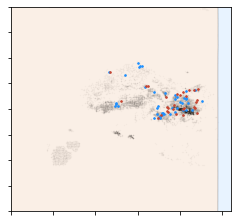

In [ ]:
# CM 2021 Uinta
Sources_prod = pd.read_csv(emission_source_path + 'Production_sources_F - GAO_2020Uinta basin_20221110.csv')
Sources_prod = cvt_point_to_geodf(Sources_prod, lonname='Longitude', latname='Latitude')
Sources_mid = pd.read_csv(emission_source_path + 'Midstream_sources_F - GAO_2020Uinta basin_20221110.csv')
Sources_mid = cvt_point_to_geodf(Sources_mid, lonname='Longitude', latname='Latitude')

# Create Uinta-only shapefile (excluding coverage in other basins)
Uinta_shapefile = basin[basin['Name']=='Uinta basin']
Uinta_wells_all = gpd.tools.sjoin(UT_wells,Uinta_shapefile,op='within',how='inner')


national_plot, ax = plt.subplots()
# states.plot(edgecolor='black', color=colors[3], alpha=0.1, ax=ax)

# Add state and water boundaries
states.loc[(states['NAME']=='Utah')].plot(edgecolor='black', color=colors[3], alpha=0.1, ax=ax)
# states.loc[(states['NAME']=='Utah')].plot(edgecolor='black', color=colors[1], alpha=0.1, ax=ax)
states.loc[(states['NAME']=='Arizona')].plot(edgecolor='black', color=colors[2], alpha=0.1, ax=ax)
states.loc[(states['NAME']=='Wyoming')].plot(edgecolor='black', color=colors[4], alpha=0.1, ax=ax)
states.loc[(states['NAME']=='Colorado')].plot(edgecolor='black', color=colors[5], alpha=0.1, ax=ax)
states.loc[(states['NAME']=='Idaho')].plot(edgecolor='black', color=colors[0], alpha=0.1, ax=ax)
# states.loc[(states['NAME']=='Oklahoma')].plot(edgecolor='black', color=colors[6], alpha=0.1, ax=ax)
states.loc[(states['NAME']=='Nevada')].plot(edgecolor='black', color=colors[7], alpha=0.1, ax=ax)
states.loc[(states['NAME']=='New Mexico')].plot(edgecolor='black', color=colors[8], alpha=0.1, ax=ax)

# Plot all wells
plt.scatter(x=Uinta_wells_all['Surface Hole Longitude (WGS84)'], y=Uinta_wells_all['Surface Hole Latitude (WGS84)'], s=background_marker_size*2, alpha=.5, marker='.', color=colors[0])

# Plot all emissions
plt.scatter(x=Sources_prod['Longitude'], y=Sources_prod['Latitude'], s=10, marker='.', color=colors[5])
plt.scatter(x=Sources_mid['Longitude'], y=Sources_mid['Latitude'], s=10, marker='.', color=colors[2])
# plt.text(-110.5, 40.6, 'Uinta', fontsize=24)

ax.set_yticklabels([])
ax.set_xticklabels([])
# plt.xlabel('Longitude', size=16)
# plt.ylabel('Latitude', size=16)
ax.set_xlim(-111.5, -108.9)
ax.set_ylim(39, 41)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
# plt.rcParams["figure.figsize"] = (3,3)
# plt.subplots_adjust(0,0,1,1,0,0)
plt.savefig(result_path + 'CM Uinta 2021 survey map 20221112b.png', format='png', bbox_inches='tight', dpi=300)

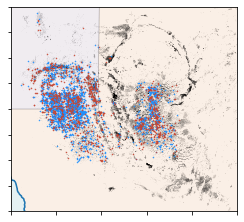

In [ ]:
# All Permian emissions plot
# CM Permian 2019 plot
CMPermian19Sources_prod = cvt_point_to_geodf(pd.read_csv(emission_source_path + 'Production_sources_P - Permian_2019Permian basin_20221110.csv'),
                                             lonname='Longitude', latname='Latitude')
CMPermian19Sources_mid = cvt_point_to_geodf(pd.read_csv(emission_source_path + 'Midstream_sources_P - Permian_2019Permian basin_20221110.csv'),
                                          lonname='Longitude', latname='Latitude')
# Kairos NM Permian plot
KairosPermianSources_prod = cvt_point_to_geodf(pd.read_csv(emission_source_path + 'Production_sources_Kairos PermianPermian basin_20221110.csv'),
                                               lonname='Longitude', latname='Latitude')
KairosPermianSources_mid = cvt_point_to_geodf(pd.read_csv(emission_source_path + 'Midstream_sources_Kairos PermianPermian basin_20221110.csv'),
                                 lonname='Longitude', latname='Latitude')
# CM 2020 Permian
CMPermian20Sources_prod = cvt_point_to_geodf(pd.read_csv(emission_source_path + 'Production_sources_F - GAO_2020Permian basin_20221110.csv'),
                                             lonname='Longitude', latname='Latitude')
CMPermian20Sources_mid = cvt_point_to_geodf(pd.read_csv(emission_source_path + 'Midstream_sources_F - GAO_2020Permian basin_20221110.csv'),
                                            lonname='Longitude', latname='Latitude')
# CM Summer 2021 Permian
CMPermianS21Sources_prod = cvt_point_to_geodf(pd.read_csv(emission_source_path + 'Production_sources_E - Permian_2021Permian basin_20221110.csv'),
                                              lonname='Longitude', latname='Latitude')
CMPermianS21Sources_mid = cvt_point_to_geodf(pd.read_csv(emission_source_path + 'Midstream_sources_E - Permian_2021Permian basin_20221110.csv'),
                                             lonname='Longitude', latname='Latitude')
# CM Fall 2021 Permian
CMPermianF21Sources_prod = cvt_point_to_geodf(pd.read_csv(emission_source_path + 'Production_sources_J - Permian Fall 2021Permian basin_20221110.csv'), lonname='Longitude', latname='Latitude')
CMPermianF21Sources_mid = cvt_point_to_geodf(pd.read_csv(emission_source_path + 'Midstream_sources_J - Permian Fall 2021Permian basin_20221110.csv'), lonname='Longitude', latname='Latitude')

national_plot, ax = plt.subplots()
# ax.set_facecolor(colors[4])
# states.plot(edgecolor='black', color='gray', alpha=0.1, ax=ax)

# Add state and water boundaries
states.loc[(states['NAME']=='Texas')].plot(edgecolor='black', color=colors[3], alpha=0.1, ax=ax)
states.loc[(states['NAME']=='New Mexico')].plot(edgecolor='black', color=colors[6], alpha=0.1, ax=ax)
countries[countries['NAME']=='Mexico'].plot(color=colors[1], alpha=0.1, ax=ax)
rivers[rivers['NAMEEN'] == 'Rio Grande'].plot(ax=ax) # The Rio Grande

# Plot all wells
plt.scatter(x=permian_wells['Surface Hole Longitude (WGS84)'], y=permian_wells['Surface Hole Latitude (WGS84)'], s=background_marker_size, alpha=0.5, marker='.', color=colors[0])

# Plot all emissions from all campaigns
plt.scatter(x=CMPermian19Sources_prod['Longitude'], y=CMPermian19Sources_prod['Latitude'], s=1, marker='.', color=colors[5])
plt.scatter(x=CMPermian19Sources_mid['Longitude'], y=CMPermian19Sources_mid['Latitude'], s=1, marker='.', color=colors[2])
plt.scatter(x=KairosPermianSources_prod['Longitude'], y=KairosPermianSources_prod['Latitude'], s=1, marker='.', color=colors[5])
plt.scatter(x=KairosPermianSources_mid['Longitude'], y=KairosPermianSources_mid['Latitude'], s=1, marker='.', color=colors[2])
plt.scatter(x=CMPermian20Sources_prod['Longitude'], y=CMPermian20Sources_prod['Latitude'], s=1, marker='.', color=colors[5])
plt.scatter(x=CMPermian20Sources_mid['Longitude'], y=CMPermian20Sources_mid['Latitude'], s=1, marker='.', color=colors[2])
plt.scatter(x=CMPermianS21Sources_prod['Longitude'], y=CMPermianS21Sources_prod['Latitude'], s=1, marker='.', color=colors[5])
plt.scatter(x=CMPermianS21Sources_mid['Longitude'], y=CMPermianS21Sources_mid['Latitude'], s=1, marker='.', color=colors[2])
plt.scatter(x=CMPermianF21Sources_prod['Longitude'], y=CMPermianF21Sources_prod['Latitude'], s=1, marker='.', color=colors[5])
plt.scatter(x=CMPermianF21Sources_mid['Longitude'], y=CMPermianF21Sources_mid['Latitude'], s=1, marker='.', color=colors[2])
# plt.text(-102.8, 33.62, 'Permian', fontsize=18)
# plt.text(-102.5, 33.61, 'Texas', fontsize=18)
# plt.text(-104.2, 33.61, 'NM', fontsize=18)
ax.set_yticklabels([])
ax.set_xticklabels([])
# plt.text(-104.7, 33.2, 'New\nMexico', fontsize=18)

# plt.xlabel('Longitude', size=16)
# plt.ylabel('Latitude', size=16)
ax.set_xlim(-105, -100)
ax.set_ylim(30, 34)
# ax.set_xlim(-105, -101)
# ax.set_ylim(30.5, 34)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
# plt.rcParams["figure.figsize"] = (6,3)
plt.savefig(result_path + 'CM Permian all survey map 20221112b.png', format='png', bbox_inches='tight', dpi=300)

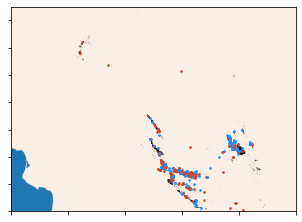

In [ ]:
# All San Joaquin surveys
# CM 2016 San Joaquin surveys
SJ16Sources_prod = cvt_point_to_geodf(pd.read_csv(emission_source_path + 'Production_sources_CA 2016San Joaquin basin_20221110.csv'), lonname='Longitude', latname='Latitude')
SJ16Sources_mid = cvt_point_to_geodf(pd.read_csv(emission_source_path + 'Midstream_sources_CA 2016San Joaquin basin_20221110.csv'), lonname='Longitude', latname='Latitude')
# CM 2017 San Joaquin
SJ17Sources_prod = cvt_point_to_geodf(pd.read_csv(emission_source_path + 'Production_sources_CA 2017San Joaquin basin_20221110.csv'), lonname='Longitude', latname='Latitude')
SJ17Sources_mid = cvt_point_to_geodf(pd.read_csv(emission_source_path + 'Midstream_sources_CA 2017San Joaquin basin_20221110.csv'), lonname='Longitude', latname='Latitude')
# CM summer 2020 San Joaquin
SJS20Sources_prod = cvt_point_to_geodf(pd.read_csv(emission_source_path + 'Production_sources_H - COVID_CA_2020San Joaquin basin_20221110.csv'), lonname='Longitude', latname='Latitude')
SJS20Sources_mid = cvt_point_to_geodf(pd.read_csv(emission_source_path + 'Midstream_sources_H - COVID_CA_2020San Joaquin basin_20221110.csv'), lonname='Longitude', latname='Latitude')
# CM fall 2020 San Joaquin
SJF20Sources_prod = cvt_point_to_geodf(pd.read_csv(emission_source_path + 'Production_sources_G - CA_2020San Joaquin basin_20221110.csv'), lonname='Longitude', latname='Latitude')
SJF20Sources_mid = cvt_point_to_geodf(pd.read_csv(emission_source_path + 'Midstream_sources_G - CA_2020San Joaquin basin_20221110.csv'), lonname='Longitude', latname='Latitude')
# CM fall 2021 San Joaquin
SJF21Sources_prod = cvt_point_to_geodf(pd.read_csv(emission_source_path + 'Production_sources_K - CA Fall 2021San Joaquin basin_20221110.csv'), lonname='Longitude', latname='Latitude')
SJF21Sources_mid = cvt_point_to_geodf(pd.read_csv(emission_source_path + 'Midstream_sources_K - CA Fall 2021San Joaquin basin_20221110.csv'), lonname='Longitude', latname='Latitude')


national_plot, ax = plt.subplots()
# states.plot(edgecolor='black', color=colors[3], alpha=0.1, ax=ax)

# Add state and water boundaries
states.loc[(states['NAME']=='California')].plot(edgecolor='black', color=colors[3], alpha=0.1, ax=ax)
states.loc[(states['NAME']=='Nevada')].plot(edgecolor='black', color=colors[6], alpha=0.1, ax=ax)
oceans[oceans['name']=='North Pacific Ocean'].plot(ax=ax)

# Plot all wells
plt.scatter(x=SJ_wells_only['Surface Hole Longitude (WGS84)'], y=SJ_wells_only['Surface Hole Latitude (WGS84)'], s=background_marker_size, alpha=0.4, marker='.', color=colors[0])

# Plot all emissions from all campaigns
plt.scatter(x=SJ16Sources_prod['Longitude'], y=SJ16Sources_prod['Latitude'], s=10, marker='.', color=colors[5])
plt.scatter(x=SJ16Sources_mid['Longitude'], y=SJ16Sources_mid['Latitude'], s=10, marker='.', color=colors[2])
plt.scatter(x=SJ17Sources_prod['Longitude'], y=SJ17Sources_prod['Latitude'], s=10, marker='.', color=colors[5])
plt.scatter(x=SJ17Sources_mid['Longitude'], y=SJ17Sources_mid['Latitude'], s=10, marker='.', color=colors[2])
plt.scatter(x=SJS20Sources_prod['Longitude'], y=SJS20Sources_prod['Latitude'], s=10, marker='.', color=colors[5])
plt.scatter(x=SJS20Sources_mid['Longitude'], y=SJS20Sources_mid['Latitude'], s=10, marker='.', color=colors[2])
plt.scatter(x=SJF20Sources_prod['Longitude'], y=SJF20Sources_prod['Latitude'], s=10, marker='.', color=colors[5])
plt.scatter(x=SJF20Sources_mid['Longitude'], y=SJF20Sources_mid['Latitude'], s=10, marker='.', color=colors[2])
plt.scatter(x=SJF21Sources_prod['Longitude'], y=SJF21Sources_prod['Latitude'], s=10, marker='.', color=colors[5])
plt.scatter(x=SJF21Sources_mid['Longitude'], y=SJF21Sources_mid['Latitude'], s=10, marker='.', color=colors[2])
# plt.text(-120.2, 36.2, 'California', fontsize=18)
# plt.text(-120.1, 36, 'San Joaquin\n(California)', fontsize=18)

ax.set_yticklabels([])
ax.set_xticklabels([])
# plt.xlabel('Longitude', size=14)
# plt.ylabel('Latitude', size=14)
ax.set_xlim(-121, -118.5)
ax.set_ylim(35, 36.5)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
# plt.rcParams["figure.figsize"] = (6,3)
plt.savefig(result_path + 'CM San Joaquin all survey map 20221112b.png', format='png', bbox_inches='tight', dpi=300)
# plt.show()

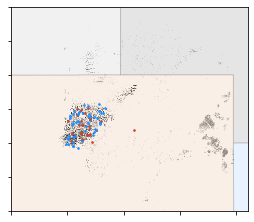

In [ ]:
# All DJ campaigns
# CM fall 2021 DJ
DJF21Sources_prod = cvt_point_to_geodf(pd.read_csv(emission_source_path + 'Production_sources_I - DJ Fall 2021Denver basin_20221110.csv'), lonname='Longitude', latname='Latitude')
DJF21Sources_mid = cvt_point_to_geodf(pd.read_csv(emission_source_path + 'Midstream_sources_I - DJ Fall 2021Denver basin_20221110.csv'), lonname='Longitude', latname='Latitude')
# CM summer 2021 DJ
DJS21Sources_prod = cvt_point_to_geodf(pd.read_csv(emission_source_path + 'Production_sources_A - DJ_Summer_2021Denver basin_20221110.csv'), lonname='Longitude', latname='Latitude')
DJS21Sources_mid = cvt_point_to_geodf(pd.read_csv(emission_source_path + 'Midstream_sources_A - DJ_Summer_2021Denver basin_20221110.csv'), lonname='Longitude', latname='Latitude')

# Create Denver Julesburg-only shapefile for California (excluding coverage in other basins)
DJ_shape = basin[basin['Name'] == 'Denver basin']
DJ_wells_all = gpd.tools.sjoin(DJ_wells,DJ_shape,op='within',how='inner')


national_plot, ax = plt.subplots()
# states.plot(edgecolor='black', color=colors[3], alpha=0.1, ax=ax)

# Add state and water boundaries
states.loc[(states['NAME']=='Colorado')].plot(edgecolor='black', color=colors[3], alpha=0.1, ax=ax)
states.loc[(states['NAME']=='Utah')].plot(edgecolor='black', color=colors[1], alpha=0.1, ax=ax)
states.loc[(states['NAME']=='Arizona')].plot(edgecolor='black', color=colors[2], alpha=0.1, ax=ax)
states.loc[(states['NAME']=='Wyoming')].plot(edgecolor='black', color=colors[4], alpha=0.1, ax=ax)
states.loc[(states['NAME']=='Kansas')].plot(edgecolor='black', color=colors[5], alpha=0.1, ax=ax)
states.loc[(states['NAME']=='Nebraska')].plot(edgecolor='black', color=colors[0], alpha=0.1, ax=ax)
states.loc[(states['NAME']=='Oklahoma')].plot(edgecolor='black', color=colors[6], alpha=0.1, ax=ax)
states.loc[(states['NAME']=='Nevada')].plot(edgecolor='black', color=colors[7], alpha=0.1, ax=ax)
states.loc[(states['NAME']=='New Mexico')].plot(edgecolor='black', color=colors[8], alpha=0.1, ax=ax)

# Plot all wells
plt.scatter(x=DJ_wells_all['Surface Hole Longitude (WGS84)'], y=DJ_wells_all['Surface Hole Latitude (WGS84)'], s=background_marker_size*1, alpha=1, marker='.', color=colors[0])

# Plot all emissions from all campaigns
plt.scatter(x=DJF21Sources_prod['Longitude'], y=DJF21Sources_prod['Latitude'], s=10, marker='.', color=colors[5])
plt.scatter(x=DJF21Sources_mid['Longitude'], y=DJF21Sources_mid['Latitude'], s=10, marker='.', color=colors[2])
plt.scatter(x=DJS21Sources_prod['Longitude'], y=DJS21Sources_prod['Latitude'], s=10, marker='.', color=colors[5])
plt.scatter(x=DJS21Sources_mid['Longitude'], y=DJS21Sources_mid['Latitude'], s=10, marker='.', color=colors[2])
# plt.text(-105.9, 39.2, 'Denver-Julesburg', fontsize=20)

ax.set_yticklabels([])
ax.set_xticklabels([])
# plt.xlabel('Longitude', size=16)
# plt.ylabel('Latitude', size=16)
ax.set_xlim(-106, -101.8)
ax.set_ylim(39, 42)
# ax.set_ylim(39, 41.1)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
# plt.rcParams["figure.figsize"] = (6,3)
plt.savefig(result_path + 'CM Denver-Julesburg all survey map 20221112b.png', format='png', bbox_inches='tight', dpi=300)